# Note
This script aims to divide the STAS into several classes based on their different features. In this script, we will use a pre-trained model (**VGG16**) to extract a feature vector from images and cluster the images based on the similarity of the feature vectors (using **KMeans** or **Hdbscan**).

In [ ]:
# Mount colab to our drive
from google.colab import drive
import os
drive.mount('/content/drive/')
os.chdir('/content/drive/My Drive/2022_趨勢_機器學習比賽/')

Mounted at /content/drive/


# Package introduction
⚫ **load_img** allows us to load an image from a file as a PIL object:

⚫ **img_to_array** allows us to convert the PIL object into a NumPy array.

⚫ **preproccess_input** is meant to prepare the image into the format the model requires. Note that we should load images with the Keras **load_img** function to guarantee the images we load are compatible with the **preprocess_input** function.

⚫ **VGG16** is the pre-trained model we’re going to use.

⚫ **KMeans** the clustering algorithm we’re going to use.

⚫ **hdbscan** another option for clustering.

⚫ **PCA** allow us to reduce the dimensions of our feature vectors.

In [ ]:
# for loading/processing the images  
from keras.preprocessing.image import load_img 
from keras.preprocessing.image import img_to_array 
from keras.applications.vgg16 import preprocess_input 

# models 
from keras.applications.vgg16 import VGG16 
from keras.models import Model
from keras.models import Sequential
from keras.layers.core import Flatten

# clustering and dimension reduction
!pip install hdbscan
import hdbscan
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# For standardization
from sklearn.preprocessing import StandardScaler

# For silhouette score method
from sklearn.metrics import silhouette_score

# for everything else
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from random import randint
import pandas as pd
import pickle

# Load data
we load the images that contains only STAS regions.

In [ ]:
img_file_path = 'OBJ_Train_Datasets/Train_images_hematoxylin_STAS_only/'
STAS = []

# creates a ScandirIterator aliased as files
with os.scandir(img_file_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith('.jpg'):
          # adds only the image files to the list
            STAS.append(file.name)
print(len(STAS))

2785


# Data preprocessing and the model
**footnote_1**: Load the VGG model and remove the output layer manually. This means that the new final layer is a fully-connected layer with 4,096 output nodes. This vector of 4,096 numbers is the feature vector that we will use to cluster the images.

**footnote_2**: This is where we put the **load_img**() and **preprocess_input**() methods to use. When loading the images we are going to set the target size to (224, 224) because the VGG model expects the images it receives to be 224x224 NumPy arrays.

**footnote_3**: Now that the final layer is removed, we can pass our image through the predict method to get our feature vector.


In [ ]:
# load the model first and pass as an argument -footnote_1
model = VGG16(include_top=True)
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)

def extract_features(file, model):
    # load the image as a 224x224 array -footnote_2
    img = load_img(file, target_size=(224,224))
    # convert from 'PIL.Image.Image' to numpy array -footnote_2
    img = np.array(img) 
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels) -footnote_2
    reshaped_img = img.reshape(1,224,224,3) 
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector  -footnote_3
    features = model.predict(imgx, use_multiprocessing=True)
    return features

553476096/553467096 [==============================] - 2s 0us/step


# Extract the feature vectors from all of the images
Now we can use this feature_extraction function to extract the features from all of the images and store the features in a dictionary with filename as the keys.

In [ ]:
data = {}

# lop through each image in the dataset
for STAS_obj in STAS:
    # try to extract the features and update the dictionary
    feat = extract_features(img_file_path+STAS_obj,model)
    data[STAS_obj] = feat

# get a list of the filenames
filenames = np.array(list(data.keys()))

# get a list of just the features.  
feat = np.array(list(data.values())) # (n_samples, 1, 4096 or 25088)

# reshape so that there are total samples of 4096 (or 25088) vectors. shape = (n_samples, 4096 or 25088)
feat = feat.reshape(-1,4096)  

# Standerdization
We Standerdize the vectors here since PCA are distance-related and we are not sure which features are more important.


In [ ]:
Mm = StandardScaler()
feat_stand = Mm.fit_transform(feature_map)    # Note that the shape of the input should be: [n_samples, n_features]

# Dimensionality Reduction (PCA)
We need to reduce the dimension of the parameter space for the following clustering method.

In [ ]:
# Dimensionality Reduction (PCA)
pca = PCA(n_components=0.6, random_state=0)
pca.fit(feat_stand)
x = pca.transform(feat_stand)

# KMeans
This algorithm will allow us to group our feature vectors into k clusters. Each cluster should contain images that are visually similar. Note that the choice of k is important, and we use **silhouette score method** to pick up the best k.

In [ ]:
# We standardize the input data before clustering. (Should we?)
Mm = StandardScaler()
x_stand = Mm.fit_transform(x)    # Note that the shape of the data: [n_samples, n_features]

In [ ]:
# KMeans clustering
# Using silhouette score method to find the best k
k_list = [2,3,4,5,6,7,8,9,10]
silhouette_scores=[]
best_score=-1
for k in k_list:
  kmeans = KMeans(n_clusters=k , random_state=22) # set current hyper parameter
  kmeans.fit(feat_stand)                                   # fit model, (feat_stand or x)
  ss = silhouette_score(feat_stand, kmeans.labels_);     # calculate silhouette_score
  silhouette_scores+=[ss]                         # store all the scores
  print('Parameter:', k, 'Score', ss);
  if ss > best_score:
      best_score = ss
      best_k = k

Parameter: 2 Score 0.3194558582854217
Parameter: 3 Score 0.32460246058167214
Parameter: 4 Score 0.3544724852852845
Parameter: 5 Score 0.2929554626297958
Parameter: 6 Score 0.30243900731263546
Parameter: 7 Score 0.29997099699837043
Parameter: 8 Score 0.30157909250267084
Parameter: 9 Score 0.2954713557557057
Parameter: 10 Score 0.28554303636588485


In [ ]:
# Now we cluster our data using the best k value.
n_clusters = 4
kmeans = KMeans(n_clusters=n_clusters , random_state=22) # set current hyper parameter
kmeans.fit(feat_stand)                                   # fit model

KMeans(n_clusters=4, random_state=22)

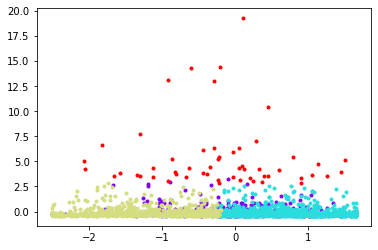

In [ ]:
# Show the KMeans label list. The order of the labels is parallel to the list of filenames for each image.
kmeans.labels_
color = cm.rainbow(np.linspace(0,1,n_clusters))
for i, c in zip(range(n_clusters),color):
  plt.scatter(feat_stand[kmeans.labels_==i,0],feat_stand[kmeans.labels_==i,1],color=c,marker='.');
# print(set(x[kmeans.labels_[kmeans.labels_==i]][:,6]))
# print(len(set(x[kmeans.labels_==i,0])))

# Group the clustering result
Now we can group the images into their clusters.

In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(img_id,kmeans.labels_): # filenames or img_id. kmeans.labels_ or hclusterer.labels_ , depending on what clustering method you use.
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

# Clone data
Now we can clone the images to the folders based on the clustering result.

In [ ]:
import shutil

src = 'OBJ_Train_Datasets/Train_images/'
cluster_num=range(n_clusters)
for num in cluster_num:
  dst = f'OBJ_Train_Datasets/Train_images_STAS_cluster/c{num}/'
  for img_num in groups[num]:
    shutil.copy(src+img_num, dst+img_num)
    continue 

# Save the clustering result
We output the clustering result as a txt file for the following YOLOv5 training.

In [ ]:
target_path = 'OBJ_Train_Datasets/Train_Images/cluster_result.txt'
cluster_result=[]
for gp in range(len(groups)):
  for j in groups[gp]:
    gp_num = gp+1
    img_name = j.split('_')[0]
    img_STAS_num = j.split('_')[1].split('.')[0]
    cluster_result.append(f'{img_name} {img_STAS_num} {gp_num} \n')
f = open(target_path,'w+')
f.writelines(cluster_result)
f.close()

# Check the clustering result
We plot the images in each cluster to check the result.

In [ ]:
import random
# function that lets you view a cluster (based on identifier)        
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    random.shuffle(files)
    # only allow up to 30 images to be shown at a time
    if len(files) > 30:
        print(f"This is cluster {cluster}. Clipping cluster size from {len(files)} to 30")
        files = files[:30]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(img_file_path+file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

This is cluster 0. Clipping cluster size from 525 to 30


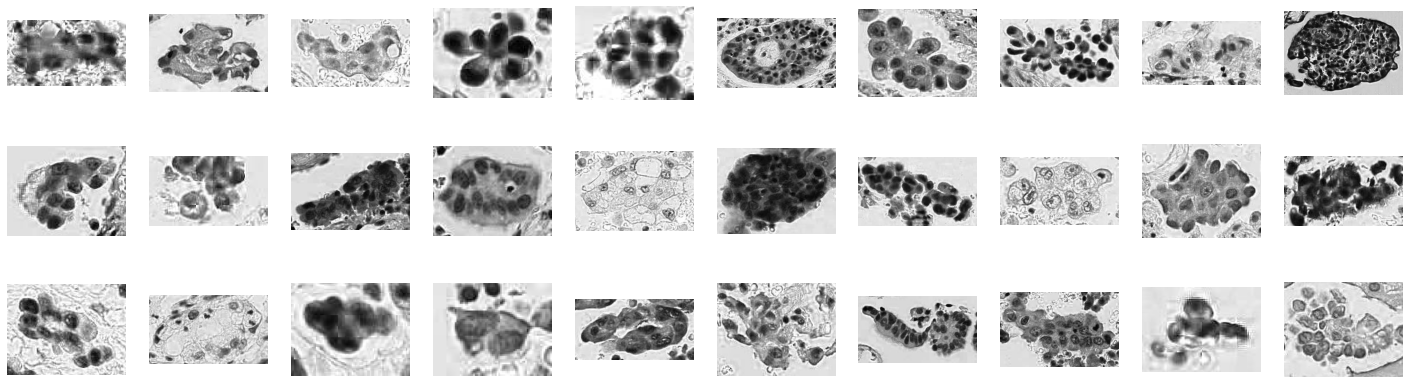

In [ ]:
view_cluster(0)

This is cluster 1. Clipping cluster size from 1353 to 30


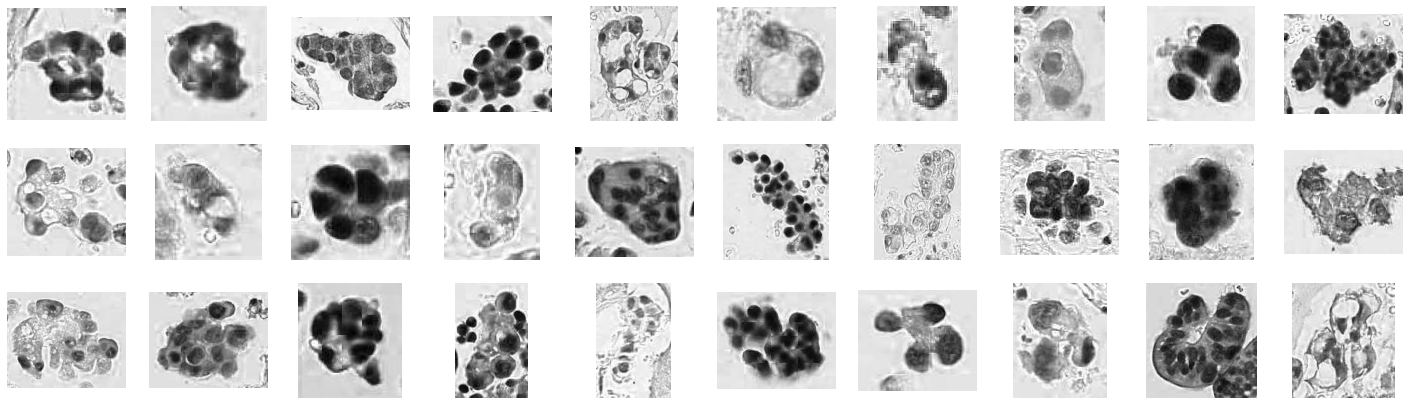

In [ ]:
view_cluster(1)

This is cluster 2. Clipping cluster size from 853 to 30


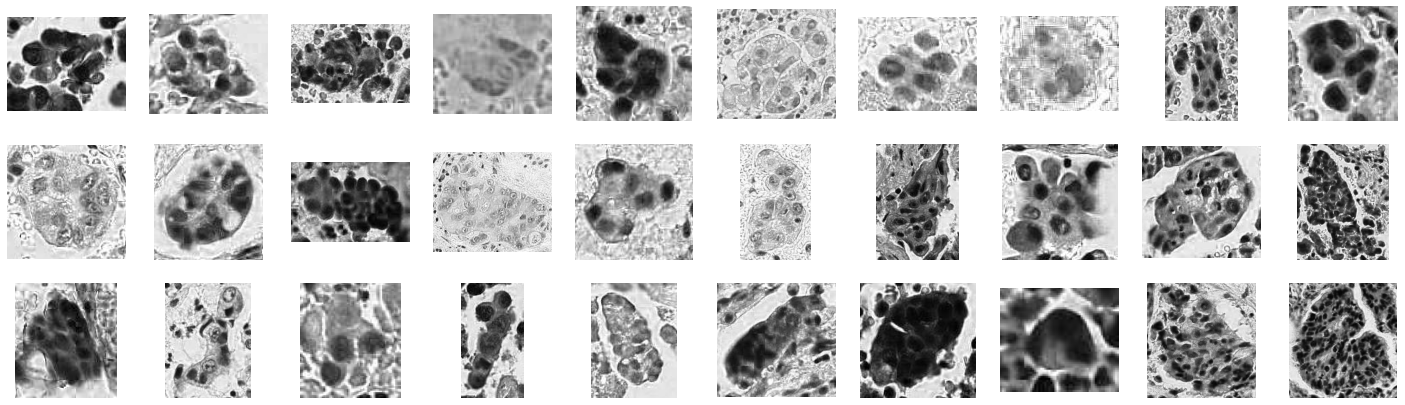

In [ ]:
view_cluster(2)

This is cluster 3. Clipping cluster size from 54 to 30


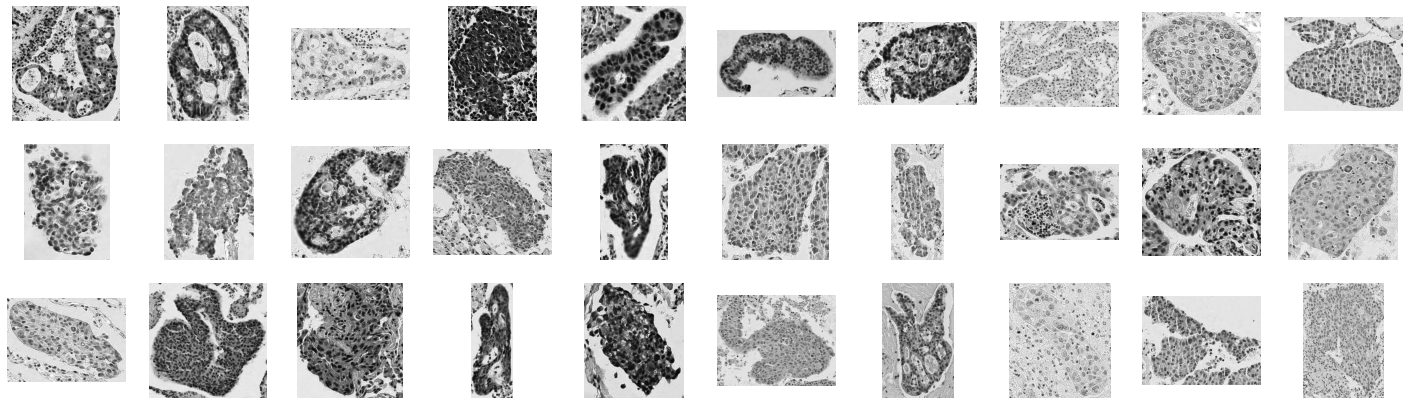

In [ ]:
view_cluster(3)